In [ ]:
import glob
import matplotlib as plt
import cv2
import os
import numpy as np
from pyefd import elliptic_fourier_descriptors
import mahotas
import matplotlib.pyplot as plt
import math
import skimage
from skimage.transform import radon,frt2,hough_circle,hough_line, hough_line_peaks


pi=math.pi
path = glob.glob("handgest3/*")
categories=["digit1","digit1p","digit2","digit2p","digit3","digit3p","digit4","digit4p","digit5","fist","pince1","pince2","tiger"]
es = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
kernel = np.ones((3,3),np.uint8)


class ZernikeMoments:
	def __init__(self, radius):
		# store the size of the radius that will be
		# used when computing moments
		self.radius = radius
	def describe(self, image):
		# return the Zernike moments for the image
		return mahotas.features.zernike_moments(image, self.radius)
    
def efd_feature(contour):
    coeffs = elliptic_fourier_descriptors(np.squeeze(contour), order=28, normalize=False)
    return coeffs.flatten()[1:]
def tf(contour1):
        
        f = np.fft.fft2(contour1)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        magnitude_spectrum = np.asarray(magnitude_spectrum, dtype=np.uint8)
        return magnitude_spectrum
k=-1
data_features=[]
for classe in path : 
                direc=glob.glob("{}/*".format(classe))
                k=k+1
                for i in direc:
                    try:

                        img=cv2.imread(i)   
                        img=cv2.resize(img,(640 ,480)) 
                        img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
                        _,t=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU+cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
                        dilat = cv2.dilate(t,kernel,iterations = 1)
                        op = cv2.morphologyEx(dilat, cv2.MORPH_OPEN,es)
                        binar_img = cv2.morphologyEx(op, cv2.MORPH_CLOSE,es)
                        lap=cv2.Laplacian(binar_img,cv2.CV_8UC1)
                        contour,_=cv2.findContours(binar_img,cv2.RETR_TREE ,cv2.CHAIN_APPROX_NONE)
                        contour1,_ =cv2.findContours(lap,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
                        from skimage.measure import label,regionprops,regionprops_table
                        from skimage import data, util
                        #--------------------label-------------------------
                        
                        label_img= label(t)
                        #---------------trensform--------------------------
                        radii = np.arange(3, 6)
                        h, theta, d = hough_line(binar_img)
                        hspace, angles, dists = hough_line_peaks(h, theta, d)
                        #---------------zernic mm--------------------------
                        desc = ZernikeMoments(21)
                        zernike = desc.describe(binar_img)
                        zernike=np.asarray(zernike)
                        #--------------fourier discriptot------------------------------------------
                        '''Tf=[]
                        for c1 in contour1:
                           Tf.append(tf(c1))
                        frq=np.concatenate(np.concatenate(np.concatenate(Tf)))
                        frqmin=np.array(frq[160:290])'''
                        for c in contour:
                         fd=efd_feature(c)
                        #----------------propeties--------------
                        props = regionprops(label_img)
                        moment=props[0].moments
                        huemoment=props[0].moments_hu
                        huemoment=np.delete(huemoment,6)
                        moment_norm=props[0].moments_normalized
                        moment_norm=np.delete(moment_norm,[0,1,4])
                        moment_cent=props[0].moments_central
                        bbox=props[0].bbox
                        orient=props[0].orientation
                        perimeter=props[0].perimeter
                        area=props[0].area
                        bboxarea=props[0].bbox_area
                        convex_area=props[0].convex_area
                        inerstia_tensor=props[0].inertia_tensor
                        inertia_tensor_eigvals=props[0].inertia_tensor_eigvals
                        extent=props[0].extent
                        local_centroid=props[0].local_centroid
                        eccentricity=props[0].eccentricity
                        solidity=props[0].solidity
                        eq_diam=props[0].equivalent_diameter
                        #filled_area=props[0].filled_area
                        #euler_number=props[0].euler_number
                        #minor_axis_length=props[0].minor_axis_length
                        #major_axis_length=props[0].major_axis_length
                        #compacite=pi*area/(perimeter**2)
                        #shannon_entropy=skimage.measure.shannon_entropy(img, base=2)
                        #if len(hspace[:8]) <8 or (angles[:20])<20 or len(dists[:20])<20:
                           # print("stop stop stop ","hspace",len(hspace[:20]) ,"angles", len(angles[:20]), "dists",len(dists[:20]),"image: ",i)
                          
                        s=np.concatenate([huemoment,moment,moment_norm,moment_cent,bbox,fd,zernike,inertia_tensor_eigvals,
                                          inerstia_tensor,perimeter,bboxarea,extent,orient,solidity,extent,
                                          local_centroid,convex_area,hspace[:13],dists[:7]],axis=None)             
                        data_features.append([k,s])
                        #break
                    except:
                        pass
                    
                    
                #break
  

In [ ]:
from skimage.feature import shape_index
s=shape_index(binar_img)

In [ ]:
from skimage.transform import radon,frt2,hough_circle,hough_line, hough_line_peaks,integral_image,ifrt2
import cv2
from skimage.feature import haar_like_feature
sinogram = radon(binar_img)
f = frt2(binar_img)
binar_img=cv2.resize(binar_img,(640 ,640))
radii = np.arange(3, 6)
h, theta, d = hough_line(binar_img)
hspace, angles, dists = hough_line_peaks(h, theta, d)
i=integral_image(binar_img)
fi = ifrt2(f)

In [ ]:
plt.imshow(img)


In [ ]:
plt.imshow(skimage.transform.pyramid_expand(binar_img,3,5,10))

In [ ]:
import random
random.shuffle(data_features)
f=0    
for j in range(len(data_features)):
 for i in data_features[j][1:]:
    for k in i:
     if k==math.inf:
        f=f+1
       
#print(f)

x,y=[],[]
for i,j in data_features:
    x.append(j)
    y.append(i)
    
for i in range(len(x)) :
 for j in range(len(x[i])) :
   if x[i][j]==math.inf :
     x[i][j]=9999

     

In [ ]:
t=0
for i in x:
    t=t+1
    if len(i) != len(x[0]): 
        print(len(i),i)

In [ ]:
import pickle
pickle.dump(x,open("x2_kppv.pickle","wb"))
pickle.dump(y,open("y2_kppv.pickle","wb"))


In [ ]:
import pickle
x=pickle.load(open("x2_kppv.pickle","rb"))
y=pickle.load(open("y2_kppv.pickle","rb"))


In [ ]:
import sklearn
import pandas as pd
from sklearn import svm,preprocessing,neighbors 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
x = preprocessing.scale(x)
x_train, x_test, y_train, y_test =train_test_split(x, y,test_size=0.3)                                    

In [ ]:

r=[]

for i in range(1,500): 
      clf=svm.SVC(C=i,decision_function_shape='ovo')
      clf.fit(x_train,y_train)
      acc=clf.score(x_test,y_test)
      r.append([acc,i])
    
print(max(r))   
#clf=svm.SVC()
#clf =svm.SVC(kernel='linear', probability=True)
#clf=svm.SVC(kernel='linear',gamma="auto",verbose=True)


In [ ]:
clf=svm.SVC(C=70,decision_function_shape='ovo')
clf.fit(x_train,y_train)
acc=clf.score(x_test,y_test)
print(acc)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
i=900
v=[]

clf1 = RandomForestClassifier(max_leaf_nodes=900,n_estimators=i,max_features='auto')
clf1 .fit(x_train,y_train)
acc=clf1.score(x_test,y_test)

print(acc)


In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
#con_mat=confusion_matrix(test_label,prediction_array, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])
def conf_matrix1(clf):
    np.set_printoptions(precision=2)
    #categories=["digit1","digit1p","digit2","digit2p","digit3","digit3p","digit4","digit4p","digit5","fist","pince1","pince2","tiger"]
    categories=["digit1","digit1p","digit2","digit2p","digit3","digit3p","digit4","digit4p","digit5","pince1"]
    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, test_features,test_label,
                                     display_labels=categories,
                                     cmap="OrRd",
                                     normalize=normalize)
        disp.ax_.set_title(title)
        disp.figure_.set_size_inches(10,10)
        #print(dir(disp.figure_))
        #print(title)
        #print(disp.confusion_matrix)
    
    plt.show()
    

In [55]:
import glob
import tensorflow as tf
import skimage
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from pyefd import elliptic_fourier_descriptors
import mahotas
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from skimage.transform import radon,frt2,hough_circle,hough_line, hough_line_peaks
#direc="C:/Users/djamel eddine/Desktop/py-project/testing"
direc="C:/Users/djamel eddine/Desktop/py-project/class/Nouveau dossier"
img_size=224
es = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
kernel = np.ones((3,3),np.uint8)


class ZernikeMoments:
	def __init__(self, radius):
		# store the size of the radius that will be
		# used when computing moments
		self.radius = radius
	def describe(self, image):
		# return the Zernike moments for the image
		return mahotas.features.zernike_moments(image, self.radius)
    
def efd_feature(contour):
    coeffs = elliptic_fourier_descriptors(np.squeeze(contour), order=35, normalize=False)
    return coeffs.flatten()[1:]
def tf(contour1):
        
        f = np.fft.fft2(contour1)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        magnitude_spectrum = np.asarray(magnitude_spectrum, dtype=np.uint8)
        return magnitude_spectrum  

data_test=[]

def preper_data():
  
  test_label=[0,1,2,3,4,5,6,7,8,8,8,9] 
  #test_label=[0,0,1,1,1,2,2,2,3,3,4,4,4,5,5,5,6,6,7,7,7,8,8,8,8,8,9]  
  
  for i in os.listdir(direc):  
                       try:
                        img=cv2.imread(os.path.join(direc,i))
                        img=cv2.resize(img,(640 ,480)) 
                        img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
                        _,t=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU+cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
                        dilat = cv2.dilate(t,kernel,iterations = 1)
                        op = cv2.morphologyEx(dilat, cv2.MORPH_OPEN,es)
                        binar_img = cv2.morphologyEx(op, cv2.MORPH_CLOSE,es)
                        lap=cv2.Laplacian(binar_img,cv2.CV_8UC1)
                        contour,_=cv2.findContours(binar_img,cv2.RETR_TREE ,cv2.CHAIN_APPROX_NONE)
                        contour1,_ =cv2.findContours(lap,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
                        from skimage.measure import label,regionprops,regionprops_table
                        from skimage import data, util
                         #--------------------label-------------------------
                        
                        label_img= label(binar_img)
                        #---------------trensform--------------------------
                        radii = np.arange(3, 6)
                        h, theta, d = hough_line(binar_img)
                        hspace, angles, dists = hough_line_peaks(h, theta, d)
                        #---------------zernic mm--------------------------
                        desc = ZernikeMoments(21)
                        zernike = desc.describe(binar_img)
                        zernike=np.asarray(zernike)
                        #--------------fourier discriptot------------------------------------------
                        '''Tf=[]
                        for c1 in contour1:
                           Tf.append(tf(c1))
                        frq=np.concatenate(np.concatenate(np.concatenate(Tf)))
                        frqmin=np.array(frq[160:290])'''
                        for c in contour:
                         fd=efd_feature(c)
                        #----------------propeties--------------
                        props = regionprops(label_img)
                        moment=props[0].moments
                        huemoment=props[0].moments_hu
                        huemoment=np.delete(huemoment,6)
                        '''moment_norm=props[0].moments_normalized
                        moment_norm=np.delete(moment_norm,[0,1,4])
                        moment_cent=props[0].moments_central
                        bbox=props[0].bbox
                        orient=props[0].orientation
                        perimeter=props[0].perimeter
                        area=props[0].area
                        bboxarea=props[0].bbox_area
                        convex_area=props[0].convex_area
                        inerstia_tensor=props[0].inertia_tensor
                        inertia_tensor_eigvals=props[0].inertia_tensor_eigvals
                        extent=props[0].extent
                        local_centroid=props[0].local_centroid
                        eccentricity=props[0].eccentricity
                        solidity=props[0].solidity
                        eq_diam=props[0].equivalent_diameter'''
                        #filled_area=props[0].filled_area
                        #euler_number=props[0].euler_number
                        #minor_axis_length=props[0].minor_axis_length
                        #major_axis_length=props[0].major_axis_length
                        #compacite=pi*area/(perimeter**2)
                        #shannon_entropy=skimage.measure.shannon_entropy(img, base=2)
                        #if len(hspace) <19 or (angles)<19 or len(dists)<19:
                            #print("stop stop stop ","hspace",len(hspace) ,"angles", len(angles), "dists",len(dists),"image: ",i)
                          
                        #s=np.concatenate([huemoment,perimeter,fd,moment,moment_norm,moment_cent,bbox,zernike,inertia_tensor_eigvals,inerstia_tensor,bboxarea,extent,orient,solidity,local_centroid,convex_area,hspace[:10],dists[:10],angles[:10]],axis=None) 
                        s=np.concatenate([huemoment,fd],axis=None) #,moment,moment_norm,moment_cent,bbox,zernike,inertia_tensor_eigvals, #inerstia_tensor,perimeter,bboxarea,extent,orient,solidity,#local_centroid,convex_area,hspace[:10],dists[:10],angles[:10]],axis=None) 
                        data_test.append(s)                  
                       except:       
                         pass                                                        
  test_features=np.array(data_test).reshape(len(data_test),-1)  
  
  return test_features,test_label
           

            
           
            

test_features,test_label=preper_data()



In [59]:
import pickle
svm=pickle.load(open("good/svml10d2car(Hue,Fd).sav","rb"))
randomforest=pickle.load(open("good/rf102car.sav","rb"))

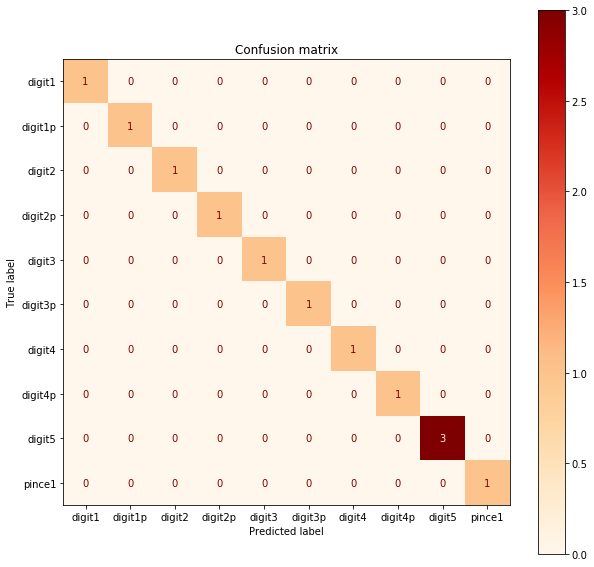

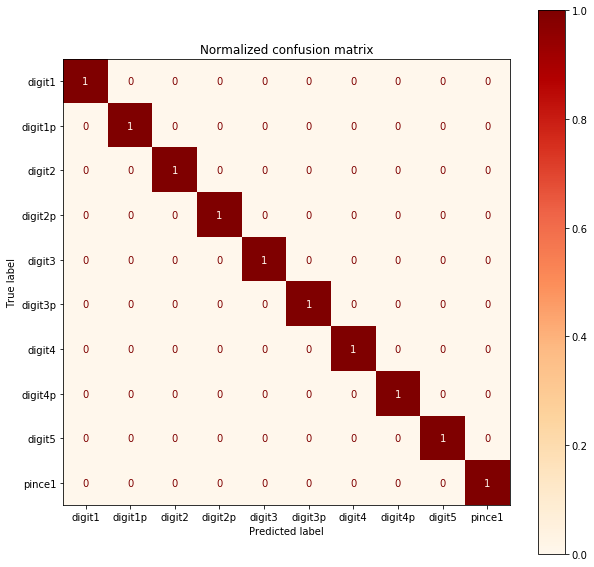

In [60]:
conf_matrix1(randomforest)

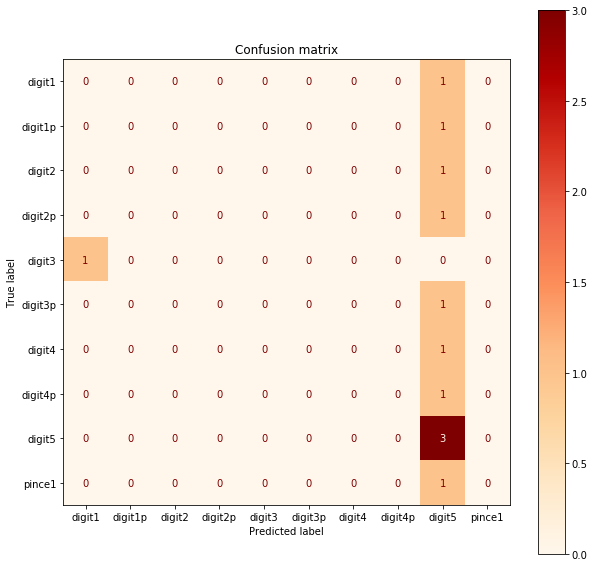

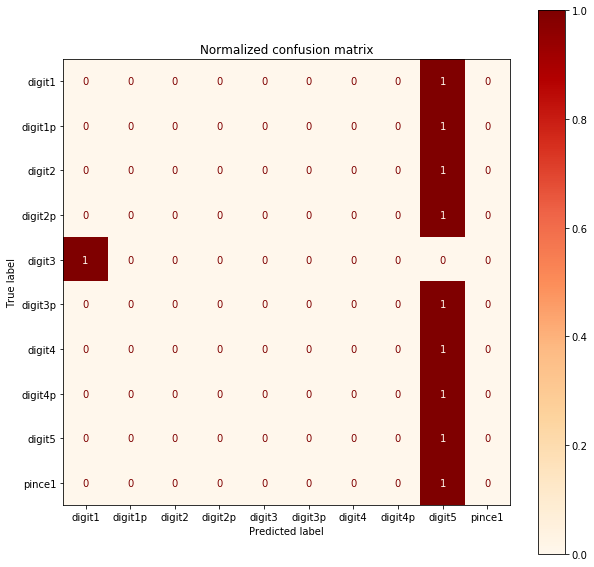

In [61]:

conf_matrix1(svm)

In [62]:
import pickle
from sklearn.model_selection import train_test_split
x=pickle.load(open("xclassifier.pickle","rb"))
y=pickle.load(open("yclassifier.pickle","rb"))
x_train, x_test, y_train, y_test =train_test_split(x, y,test_size=0.3)  
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
naive_bais= GaussianNB().fit(x_train,y_train)
kppv=neighbors.KNeighborsClassifier().fit(x_train,y_train)
print('nb=',naive_bais.score(x_test,y_test),'kppv=',kppv.score(x_test,y_test))

nb= 0.5487179487179488 kppv= 0.6935897435897436


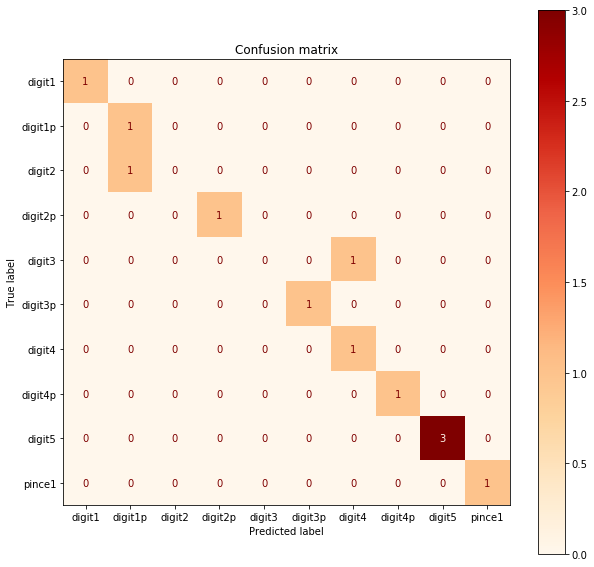

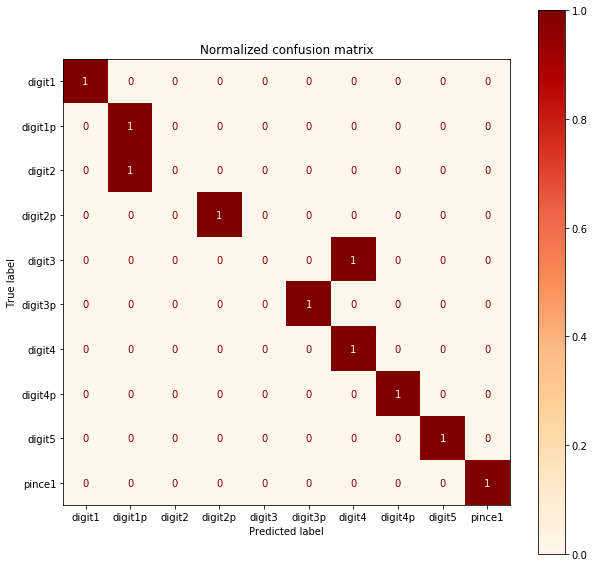

In [63]:
conf_matrix1(kppv)

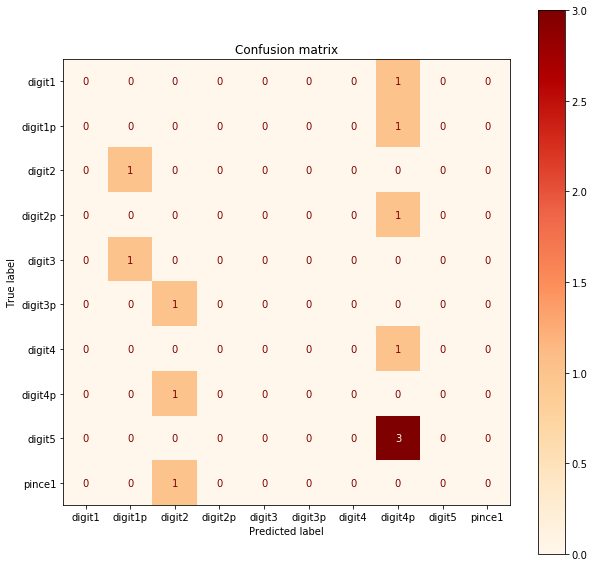

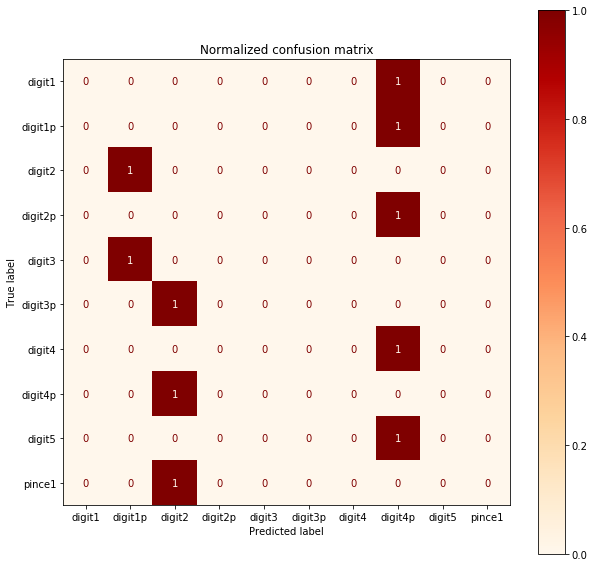

In [65]:
conf_matrix1(naive_bais)


In [96]:
'''def conf_matrix(test_features,test_label,classifier,i):
        categories=["digit1","digit1p","digit2","digit2p","digit3","digit3p","digit4","digit4p","digit5","fist","pince1","pince2","tiger"]
        
        #prediction_array=classifier.predict(test_features)
        con_mat=sklearn.metrics.confusion_matrix(test_label,prediction_array)
        figure = plt.figure(figsize=(20, 20)) 
        xticklabels,yticklabels=[],[]
        for c in categories :
            xticklabels.append('{}'.format(c))
            yticklabels.append('{}'.format(c))

        sn.set(font_scale=1.5)
        hm=sn.heatmap(con_ma,annot=True,xticklabels=xticklabels, yticklabels=yticklabels,cmap="OrRd")
        hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
        hm.set_xticklabels(hm.get_xticklabels(), rotation=90)
        plt.tight_layout()
        plt.title("confusion matrix")
        plt.xlabel('model_Prediction')
        plt.ylabel('true_predection')
        plt.show()              
       '''


In [68]:
import sklearn
def conf_proba(classifier):
    categories=["digit1","digit1p","digit2","digit2p","digit3","digit3p","digit4","digit4p","digit5","pince1"]

    #prediction_array=classifier.predict(test_features)
    prediction_array=classifier.predict_proba(test_features)


    #con_mat=sklearn.metrics.confusion_matrix(test_label,prediction_array[i])
    figure = plt.figure(figsize=(10, 10)) 
    xticklabels,yticklabels=[],[]


    for c in categories :
     xticklabels.append('{}'.format(c))

    yticklabels=["digit1","digit1p","digit2","digit2p","digit3","digit3p","digit4","digit4p",
         "digit5(1)","digit5(2)","digit5(3)","pince1"]
    sn.set(font_scale=1.5)
    hm=sn.heatmap(prediction_array,annot=True,xticklabels=xticklabels, yticklabels=yticklabels,cmap="OrRd")
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
    hm.set_xticklabels(hm.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.title("confusion matrix_prba")
    plt.xlabel('model_Prediction')
    plt.ylabel('image name')
    plt.show()              

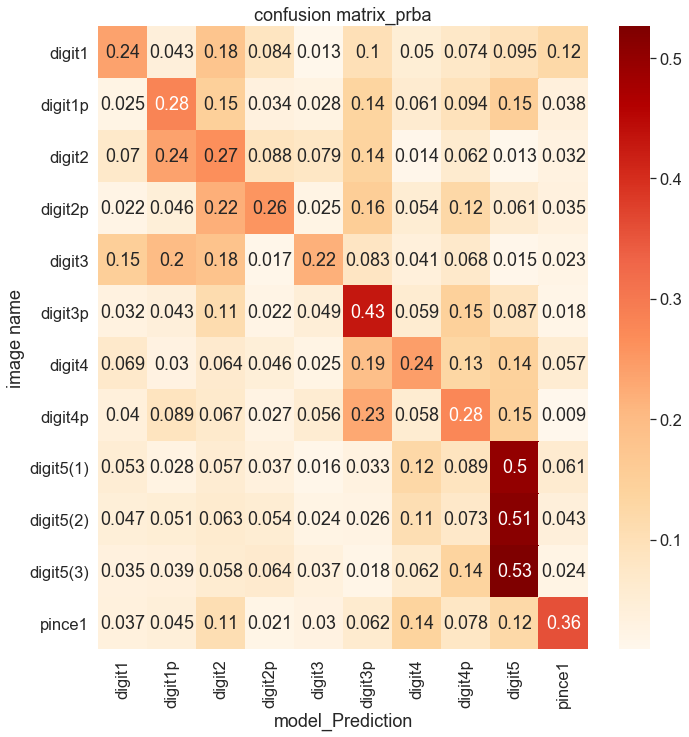

In [69]:
conf_proba(randomforest)

In [215]:
randomforest.score(x_test,y_test)


0.967948717948718

In [216]:
svm.score(x_test,y_test)

0.8756410256410256

In [ ]:
'''import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import pickle
clf=pickle.load(open("svmmodel.sav","rb"))
clf1=pickle.load(open("randomtreemodel.sav","rb"))
y_test=np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0],
       [0,0,1,0,0,0,0,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,1,0,0,0,0,0]])
x,y=preper_data()
y_prob= clf1.predict_proba(x)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))'''

In [240]:
randomforest.predict_proba(test_features)

array([[0.21, 0.02, 0.2 , 0.08, 0.03, 0.09, 0.05, 0.06, 0.13, 0.12],
       [0.01, 0.2 , 0.18, 0.03, 0.08, 0.13, 0.06, 0.12, 0.16, 0.04],
       [0.15, 0.16, 0.19, 0.06, 0.19, 0.12, 0.03, 0.06, 0.01, 0.03],
       [0.03, 0.03, 0.21, 0.27, 0.03, 0.13, 0.05, 0.12, 0.09, 0.04],
       [0.19, 0.17, 0.17, 0.02, 0.23, 0.09, 0.03, 0.05, 0.02, 0.02],
       [0.03, 0.03, 0.1 , 0.03, 0.08, 0.38, 0.07, 0.15, 0.12, 0.01],
       [0.05, 0.03, 0.07, 0.04, 0.04, 0.18, 0.25, 0.11, 0.15, 0.07],
       [0.03, 0.07, 0.09, 0.03, 0.06, 0.23, 0.04, 0.25, 0.18, 0.02],
       [0.04, 0.03, 0.07, 0.03, 0.03, 0.04, 0.12, 0.11, 0.46, 0.07],
       [0.04, 0.04, 0.06, 0.06, 0.03, 0.04, 0.11, 0.1 , 0.49, 0.04],
       [0.03, 0.04, 0.06, 0.06, 0.04, 0.03, 0.04, 0.16, 0.51, 0.03],
       [0.04, 0.04, 0.11, 0.01, 0.04, 0.06, 0.12, 0.08, 0.16, 0.35]])

In [175]:
import cv2
import PIL.Image, PIL.ImageTk
import numpy as np
import math
import skimage
from skimage.measure import label,regionprops,regionprops_table
from pyefd import elliptic_fourier_descriptors
import time
from sklearn.ensemble import RandomForestClassifier
from skimage.color import label2rgb
from socket import *
import pickle
import sys
import mahotas
from functools import lru_cache,wraps,partial
from numba import jit,njit,vectorize,double
import timeit


Populating the interactive namespace from numpy and matplotlib


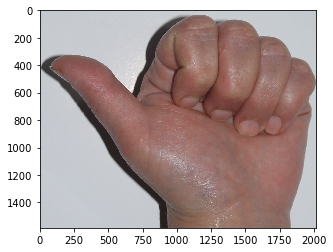

In [176]:
%pylab inline
direc="C:/Users/djamel eddine/Desktop/py-project/gest/digit1p.jpg"
img_size=224
img=cv2.imread(direc)
frame= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
_,mask=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU+cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
plt.imshow(frame)

In [243]:


def efd_feature(contour):
    def cached_wrapper(contour):
        coeffs = elliptic_fourier_descriptors(np.squeeze(contour), order=35, normalize=False)
        co= coeffs.flatten()[1:]
        return co
       
    def lru_wrapper(array=None):
        @lru_cache(maxsize=10000)
        def foo(key):
            return '%s:' % key, array
        return foo
    wrapper=lru_wrapper(array=cached_wrapper(contour))
    
    return wrapper


@jit
def data_preper (frame,mask):
     frame=cv2.flip(frame,1)
     frame=cv2.resize(frame,(img_size,img_size))
     mask=cv2.flip(mask,1)
     mask=cv2.resize(mask,(img_size,img_size))
     data_test=[]
     contour,_=cv2.findContours(mask,cv2.RETR_TREE ,cv2.CHAIN_APPROX_NONE)
      #--------------------label-------------------------
     label_img= label(mask)
     #--------------fourier discriptot------------------------------------------
     for cnt in contour:
               fd=efd_feature(cnt)
     print(fd)
     #----------------propeties--------------
     props = regionprops(label_img)
     moment=props[0].moments
     huemoment=props[0].moments_hu
     huemoment=np.delete(huemoment,6)
     s=np.concatenate([huemoment,fd],axis=None)
     data_test.append(s)
     test_features=np.array(data_test)           
     return  test_features
           


In [247]:
data_preper(frame,mask)

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
      dtype=object)